# Image reconstruction using Poutyne

In this example, we train a simple convolutional autoencoder (Conv-AE) on the MNIST dataset to learn image reconstruction. The Conv-AE is composed of two parts: an encoder and a decoder. The encoder encodes the input images to extract compact image features. The decoder, on the other hand, decodes the extracted features, to reconstruct the input image.

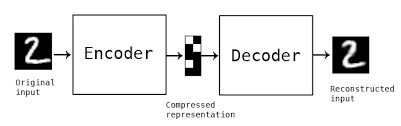

In [37]:
%pip install poutyne

Let’s import all the needed packages.

In [38]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import math
import os
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset


import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torchvision.utils import make_grid


import poutyne
from poutyne import set_seeds, Model, Experiment, ModelCheckpoint, CSVLogger



# Training constants

In [39]:
num_epochs = 3
learning_rate = 0.001
batch_size = 32
image_size = 224
val_split_percent = 0.2
momentum = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The running processor is...', device)
set_seeds(42)

The running processor is... cuda


# Loading the MNIST dataset

The MNIST dataset is directly donlowded from the `torchvision.datasets`. The training dataset contains 60,000 images of digits at the size of 28x28, However we seperate 20% of the full train dataset as validation dataset. On the other hand by passing "train" argument as `False`, the test dataset, containing 10,000 images is downloaded and saved in the dataset directory.

In [40]:
if not os.path.exists('dataset'): os.mkdir('dataset')   # making a directory to download and save the datasets

full_train_dataset = datasets.MNIST('./dataset/', train=True, download=True, transform=tfms.ToTensor())
test_dataset = datasets.MNIST('./dataset/', train=False, download=True, transform=tfms.ToTensor())

# Selecting and seperating rate% of the full_train_dataset to create validation dataset
indices = list(np.arange(len(full_train_dataset)))
np.random.shuffle(indices)
trn_indices = indices[math.floor(len(full_train_dataset)*val_split_percent):]
val_indices = indices[:math.floor(len(full_train_dataset)*val_split_percent)]


trn_dataset = Subset(full_train_dataset, trn_indices)
val_dataset = Subset(full_train_dataset, val_indices)

The format of the downloaded MNIST dataset, is proper for a classification application, which means each sample is compsed of an image and the lable (eual to the number which that images shows). However, for image reconstruction the dataset should contain an input image and a target image, which simply are the same. Hense, using the code below, we define a new dataset, which provides an image as an input and sets that image as its target as well. In other words, we change the format of each dataset sample, form (image, lable) to the (image, image).

In [41]:
class mydataset(Dataset):       
        
    
        def __init__(self, dataset):
            self.dataset = dataset
            
        
        def __getitem__(self, index):
            
            input_image = self.dataset[index][0]
            reconstructed_image = input_image  # in image reconstruction input and traget images are the same
            
            return input_image, reconstructed_image
        def __len__(self):
            
            return len(self.dataset)   


Finally, in the section below, we create the right format of the dataset and the dataloader.

In [42]:
trn_dataset_new = mydataset(trn_dataset)
val_dataset_new = mydataset(val_dataset)
test_dataset_new = mydataset(test_dataset)

trn_dataloader = DataLoader(trn_dataset_new, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_new, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset_new, batch_size=1, shuffle=False)

# Convolutional autoencoder

In [43]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        #encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        #decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)

    def forward(self, x):
        
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        x = torch.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
                
        return x


network = ConvAutoencoder()
print(network)

ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In order to interact with the optimization process, call backs are defined and saved, using the codes below, which saves the lastweights, best weights and the logs, in row.

In [44]:
#callbacks

save_path = 'saves'

# Creating saving directory 
os.makedirs(save_path, exist_ok=True)

callbacks = [
# Save the latest weights to be able to continue the optimization at the end for more epochs.
ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),

# Save the weights in a new file when the current model is better than all previous models.
ModelCheckpoint(os.path.join(save_path, 'best_weight.ckpt'),
                save_best_only=True, restore_best=True, verbose=True),

# Save the losses for each epoch in a TSV.
CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [45]:
# specifying loss and optimization function

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

## Training

In [46]:
# Poutyne Model on GPU
model = Model(network, optimizer, criterion, device=device)

# Train
model.fit_generator(trn_dataloader, val_dataloader, epochs=num_epochs, callbacks=callbacks, progress_options={'coloring': False})

Epoch: 1/3 Train steps: 1500 Val steps: 375 14.97s loss: 0.034684 val_loss: 0.016440
Epoch 1: val_loss improved from inf to 0.01644, saving file to saves/best_weight.ckpt
Epoch: 2/3 Train steps: 1500 Val steps: 375 15.23s loss: 0.015050 val_loss: 0.014121
Epoch 2: val_loss improved from 0.01644 to 0.01412, saving file to saves/best_weight.ckpt
Epoch: 3/3 Train steps: 1500 Val steps: 375 15.02s loss: 0.013616 val_loss: 0.013226
Epoch 3: val_loss improved from 0.01412 to 0.01323, saving file to saves/best_weight.ckpt
Restoring model from saves/best_weight.ckpt


[{'epoch': 1,
  'loss': 0.034683636932323375,
  'time': 14.974509695000052,
  'val_loss': 0.016440162733197212},
 {'epoch': 2,
  'loss': 0.015049613161633411,
  'time': 15.232882977999907,
  'val_loss': 0.014120550679663817},
 {'epoch': 3,
  'loss': 0.013616394124304255,
  'time': 15.022017608999704,
  'val_loss': 0.013226173773407936}]

# A random batch of the MNIST dataset images.

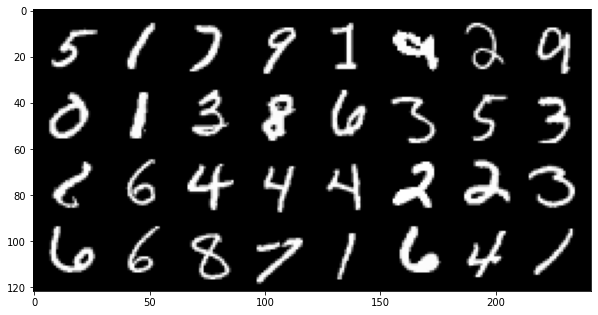

In [47]:
inputs = next(iter(trn_dataloader))[0]
input_grid = make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

## Reconstructed images after 3 epochs of training

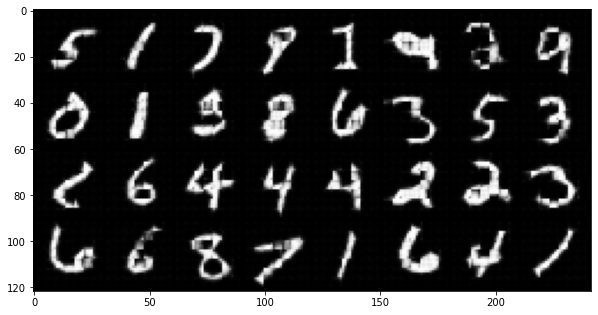

In [48]:
# Calculating predictions of the trained network on a batch
outputs = torch.tensor(model.predict_on_batch(inputs))

output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.show()

## Evaluation

One of the strong and usefull tools in poutyne is the `evaluate` class, which not only provides you with the evaluation metrics, but also provides the ground truth and the prediction, if the related arguments has been set to `True` (as below).

In [49]:
# evaluating thetrained network on test data
loss, predictions, ground_truth = model.evaluate_generator(test_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 10000 29.56s test_loss: 0.012834                                  


In most of the computer vision applications, such as image reconstruction, it is very important to check the networks failures (or abilities, vice versa). The following part shows the input and the recontructed images, as well as the reconstruction error map. Reconstruction error map show which part of the image has not been reconstructed accurately.

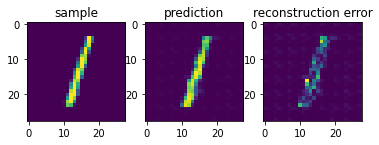

In [50]:
sample_number = 2   # a sample from test dataset

sample = ground_truth[sample_number][0]
sample_prediction_result_3epochs = predictions[sample_number][0]

recunstruction_error_map_3epochs = sample - sample_prediction_result_3epochs  #reconstruction error map
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(sample)
ax1.set_title('sample')


ax2.imshow(sample_prediction_result)
ax2.set_title('prediction')


ax3.imshow(np.abs(recunstruction_error_map))
ax3.set_title('reconstruction error')

plt.show()

# Resuming the training for more epochs

The code below shows how we can take advantage of Poutyne to resume training from a special epoch. For example, if we found the past epochs not enough, we can resume the training from the last done epoch, as below:

In [51]:
model.fit_generator(trn_dataloader, val_dataloader, epochs=13, callbacks=callbacks, initial_epoch=num_epochs)

Epoch:  3/13 Train steps: 1500 Val steps: 375 15.56s loss: 0.012901 val_loss: 0.012659
Epoch 3: val_loss improved from 0.01323 to 0.01266, saving file to saves/best_weight.ckpt
Epoch:  4/13 Train steps: 1500 Val steps: 375 14.99s loss: 0.012401 val_loss: 0.012193
Epoch 4: val_loss improved from 0.01266 to 0.01219, saving file to saves/best_weight.ckpt
Epoch:  5/13 Train steps: 1500 Val steps: 375 15.25s loss: 0.011965 val_loss: 0.011764
Epoch 5: val_loss improved from 0.01219 to 0.01176, saving file to saves/best_weight.ckpt
Epoch:  6/13 Train steps: 1500 Val steps: 375 15.34s loss: 0.011613 val_loss: 0.011474
Epoch 6: val_loss improved from 0.01176 to 0.01147, saving file to saves/best_weight.ckpt
Epoch:  7/13 Train steps: 1500 Val steps: 375 14.49s loss: 0.011360 val_loss: 0.011279
Epoch 7: val_loss improved from 0.01147 to 0.01128, saving file to saves/best_weight.ckpt
Epoch:  8/13 Train steps: 1500 Val steps: 375 14.62s loss: 0.011156 val_loss: 0.011041
Epoch 8: val_loss improved f

[{'epoch': 3,
  'loss': 0.012900817014897863,
  'time': 15.556147178999709,
  'val_loss': 0.012658503328760465},
 {'epoch': 4,
  'loss': 0.012401339183251063,
  'time': 14.989908592999655,
  'val_loss': 0.01219252527753512},
 {'epoch': 5,
  'loss': 0.011964709826434652,
  'time': 15.25233406299958,
  'val_loss': 0.011764211711784205},
 {'epoch': 6,
  'loss': 0.011612704527874787,
  'time': 15.339449304000027,
  'val_loss': 0.011473607555031776},
 {'epoch': 7,
  'loss': 0.011360241916030646,
  'time': 14.491784179000206,
  'val_loss': 0.011278786674141884},
 {'epoch': 8,
  'loss': 0.01115558298987647,
  'time': 14.621045320000121,
  'val_loss': 0.01104057609041532},
 {'epoch': 9,
  'loss': 0.010973296554138263,
  'time': 15.575266732999808,
  'val_loss': 0.010897215629617374},
 {'epoch': 10,
  'loss': 0.010825558017318448,
  'time': 15.13788250000016,
  'val_loss': 0.010778629496693611},
 {'epoch': 11,
  'loss': 0.010715000240753095,
  'time': 15.51579423999965,
  'val_loss': 0.01070401

## Reconstructed images after the second training process

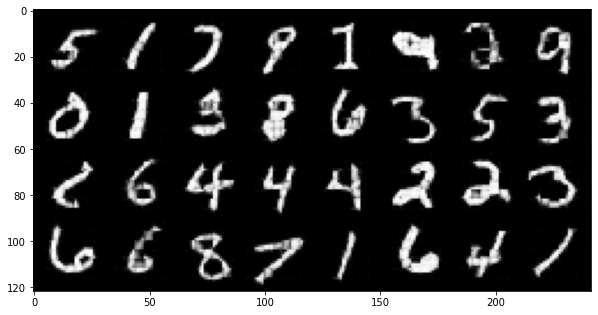

In [52]:
outputs = torch.tensor(model.predict_on_batch(inputs))

output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.show()

In [53]:
loss, predictions, ground_truth = model.evaluate_generator(test_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 10000 29.68s test_loss: 0.010215                                  


Here, we compare the reconstruction accuracy of the network after 3 epochs and 13 epochs of training.

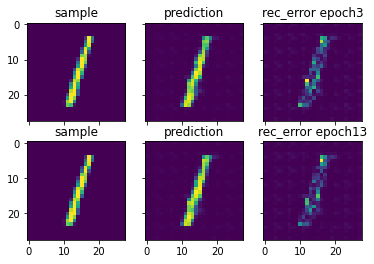

In [57]:
sample_number = 2 

sample = ground_truth[sample_number][0]
sample_prediction_result_13epochs = predictions[sample_number][0]

recunstruction_error_map_13epochs = sample - sample_prediction_result_13epochs  #reconstruction error map
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

axs[0, 0].imshow(sample)
axs[0, 0].set_title('sample')


axs[0, 1].imshow(sample_prediction_result)
axs[0, 1].set_title('prediction')


axs[0, 2].imshow(np.abs(recunstruction_error_map))
axs[0, 2].set_title('rec_error epoch3')

axs[1, 0].imshow(sample)
axs[1, 0].set_title('sample')


axs[1, 1].imshow(sample_prediction_result_13epochs)
axs[1, 1].set_title('prediction')


axs[1, 2].imshow(np.abs(recunstruction_error_map_13epochs))
axs[1, 2].set_title('rec_error epoch13')



plt.show()

You can also try more finetuning, by changing the hyperparameters (network capacity, epochs, etc) to increase the acuracy as much as you want.